<a href="https://colab.research.google.com/github/FranciscoLuna/curso_ICE_STM32CUBEIDE/blob/master/Fashion_MNIST_y_Convoluciones_entrenamiento%2C_evaluacion_y_descarga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de tipos de ropa con Redes Neuronales Convolucionales (CNN)

Esta Guia entrena un modelo de red neuronal para clasificar imagenes de ropa como, tennis y camisetas. No hay problema sino entiende todos los detalles; es un repaso rapido de un programa completo de Tensorflow con los detalles explicados a medida que avanza.

Esta Guia usa [tf.keras](https://www.tensorflow.org/guide/keras), un API de alto nivel para construir y entrenar modelos en Tensorflow.

In [ ]:
# Antes de nada, importamos las librerías que nos puedan hacer falta

import tensorflow as tf # Para crear modelos de Aprendizaje Profundo 

import matplotlib.pyplot as plt # Para graficar imágenes y gráficas de evaluación

import numpy as np # Nos permite trabajar con estructuras vectoriales eficientes
                   # que son además las que emplea tensorflow 

import math # Operaciones matemáticas

# métodos para calcular métricas y matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report 

import itertools # funciones eficientes sobre elementos iterables

## El dataset de moda de MNIST

Fashion MNIST contiene mas de 70,000 imagenes divididas en 10 categorias de prendas. Al igual que ocurria con el dataset clásico MNIST, cada imagen tiene una resolución de 28 por 28 pixeles.

En tanto que las imágenes son más complejas, su clasificación por una red es más compleja. Por ello, vamos a usar una Red Neuronal con Convoluciones para resolver el problema.

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
n_samples_train = len(x_train)
n_samples_test = len(x_test)
n_samples = n_samples_train + n_samples_test
print("La relación de muestras entre los dos subconjuntos es del {:.2%} en " 
        "subconjunto de entrenamiento y del {:.2%}, de prueba".format(
            n_samples_train/n_samples, n_samples_test/n_samples))


# Las imágenes están en escala de grises, con una resolución de 256 valores. Es
# común en problemas de clasificación realizar una normalización y escalar ese
# rango de valores al intervalo [0,1], si bien no es necesario. Puede probarse el
# realizar el entrenamiento sin hacer esta conversión.
x_train, x_test = x_train / 255.0, x_test / 255.0

La relación de muestras entre los dos subconjuntos es del 85.71% en subconjunto de entrenamiento y del 14.29%, de prueba


In [ ]:
# Una pequeña función para graficar muestras aleatorias

def random_sample_plot(n_samples, mnist_set):

  rnd_index = np.random.choice(mnist_set.shape[0], size=(n_samples,), replace=False)
  subset = mnist_set[rnd_index]

  grid_width = 5
  grid_length = math.ceil(n_samples/grid_width)
  
  plt.figure(figsize=(15,10)) # specifying the overall grid size

  for i in range(n_samples):
      plt.subplot(grid_length,grid_width,i+1)    # the number of images in the grid is 5*5 (25)
      plt.imshow(subset[i], cmap='gray')

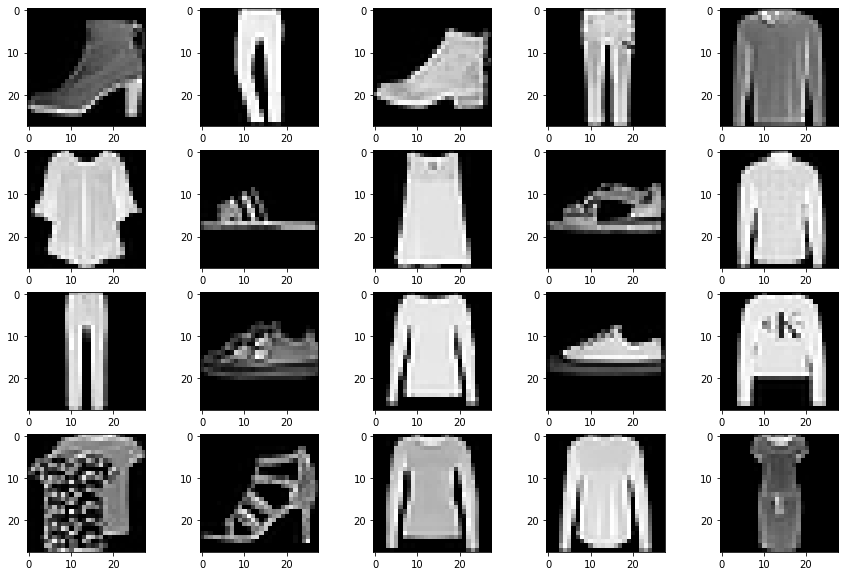

In [ ]:
# Una muestra del MNIST
random_sample_plot(20, x_train)

## Un modelo de CNN sencillo

Construir la red neuronal requiere configurar las capas del modelo y luego compilar el modelo.

In [ ]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [ ]:

model = tf.keras.models.Sequential() # El modelo secuencial vacio inicialmente


model.add(tf.keras.Input(shape=(28, 28, 1))) # Podemos describir la forma de la entrada
                                          # como si de una capa se tratase. 


# Capas de convolución y pooling

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
#model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
#model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))


model.add(tf.keras.layers.Flatten()) # Esta capa "aplana" la imagen, es decir, pasa
                                     # la matriz de valores a un vector unidimensional.
model.add(tf.keras.layers.Dense(128, activation='relu')) # Una capa Densa o Fully-Connected.
model.add(tf.keras.layers.Dropout(0.2)) # Empleamos Dropout, una técnica que inhabilita 
                                        # un % de nodos de la capa anterior de forma aleatoria
                                        # durante el entrenamiento, que ayuda a la generalización
                                        # del modelo evitando el sobre ajuste de los nodos a los
                                        # ejemplos particulares usados.
model.add(tf.keras.layers.Dense(10, activation='softmax')) # Una última capa Densa, ya como salida.
                                                           # Se la ha dotado de 10 nodos, tantos como
                                                           # dígitos diferentes consideramos para su 
                                                           # clasificación (0 al 9)

In [ ]:
model.summary() # Con este método podemos comprobar que nuestra red tiene las 
                # capas añadidas y ver alguna información adicional

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               802944    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 804,554
Trainable params: 804,554
Non-trainable params: 0
________________________________________________

### Entrenamiento del modelo

Elegimos un optimizador y una funcion de perdida para el entrenamiento del modelo.

In [ ]:
# El modelo se inicializa para su entrenamiento con el método compile
# El loss SparseCategoricalCrossEntropy permite introducir las etiquetas sin
# necesidad de codificarlas en One-Hot
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Con este método del modelo podemos entrenarlo. El parámetro "validation_data"
# es opcional y simplemente evalúa el modelo con los datos proporcionados en cada
# época, pero no serán empleados para el entrenamiento (en nuestro caso, le hemos
# proporcionado el subconjunto de prueba)
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4077 - accuracy: 0.8549
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2783 - accuracy: 0.8992
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2399 - accuracy: 0.9117
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2113 - accuracy: 0.9212
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1871 - accuracy: 0.9297
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1660 - accuracy: 0.9375
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1481 - accuracy: 0.9440
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1322 - accuracy: 0.9508
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1203 - accuracy: 0.9550
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.108

### Evaluando el modelo

El modo más básico de evaluar un modelo de clasificación es a partir de la métrica de precisión o accuracy. 

In [ ]:
# Cálculo de la precisión con el método evaluate del modelo, empleando el subconjunto de prueba
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.2831 - accuracy: 0.9176


[0.2830673158168793, 0.9175999760627747]

Se pueden emplear otro tipo de métricas. Podemos obtener algunas con la ayuda de la librería para Inteligencia Artificial Scikit Learn

In [ ]:
def otras_metricas(logits, ground_truth, classes):
  logits = np.argmax(logits, axis=1)
  print(classification_report(ground_truth, logits,
                              target_names=classes))

In [ ]:
# Llamamos al modelo para que calcule las clasificaciones con el subconjunto de
# prueba
predicts = model.predict(x_test)

# Hallamos las métricas
otras_metricas(predicts, y_test, classes=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.86      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.82      0.91      0.86      1000
       Dress       0.91      0.93      0.92      1000
        Coat       0.89      0.85      0.87      1000
      Sandal       0.99      0.96      0.98      1000
       Shirt       0.80      0.74      0.77      1000
     Sneaker       0.94      0.99      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



No obstante, si es interesante saber que la mayor parte de estas métricas se calculan a partir de datos que quedan reflejados en lo que es denominado una **matriz de confusión**, la cual ilustra la cantidad de aciertos y fallos cometidos por el modelo, de forma desglosada. 

Vamos a mostrar esta matriz para el modelo entrenado.

In [ ]:
# Función que convierte las salidas del modelo en una clase, para que pueda ser 
# asimilado por la función de cálculo de la matriz de confusión de SciKit Learn
def confusion_matrix_v2(logits, ground_truth):
  
  logits = np.argmax(logits, axis=1)
  
  cm = confusion_matrix(ground_truth, logits)

  return cm


# Una función para hacer más atractiva e intuitiva la matriz de confusión
def plot_pretty_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  plt.rcParams["figure.figsize"] = (len(classes),len(classes))

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('Etiquetas del dataset')
  plt.xlabel('Predicciones/clasificación del modelo')


Normalized confusion matrix


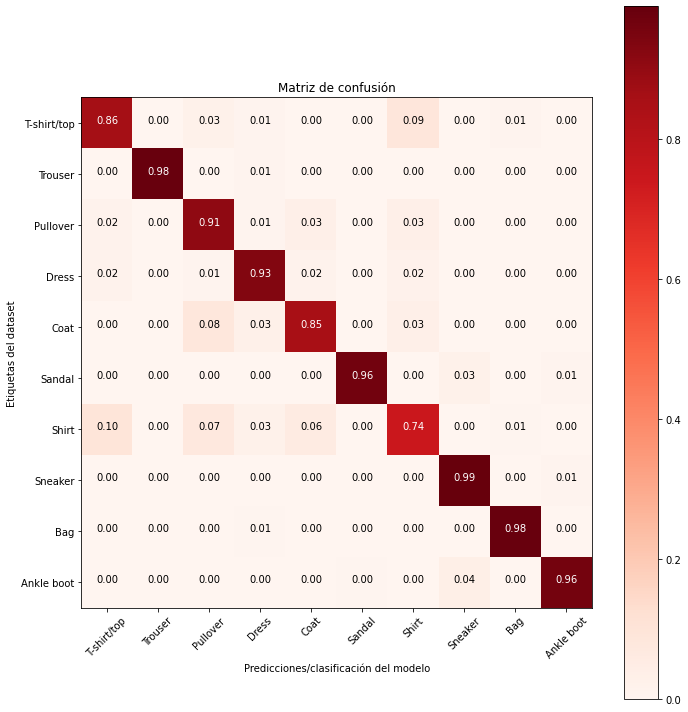

In [ ]:
# Calculamos la matriz de confusión de nuestro modelo, comparando los resultados
# con las etiquetas del dataset correspondiente a cada muestra
cm = confusion_matrix_v2(predicts, y_test)

# Mostramos la matriz de confusión de forma intuitiva
plot_pretty_confusion_matrix(cm, classes=class_names,
                          normalize=True,
                          title='Matriz de confusión',
                          cmap=plt.cm.Reds)

## ¿Te animas a continuar? 

Con lo anterior ya tenemos un modelo a nuestra disposición. Sin embargo, quedan una serie de pasos por realizar para trabajar y exprimir las utilidades de CUBE IDE. En concreto, falta por realizar:

1. **Esencial**: descargar el modelo de Keras para embeberlo en CUBE-AI. ***Nota***: recuerda que puede haber problemas de versiones, por lo que es recomendable hacer un downgrade de la versión de Tensorflow.

2. **Interesante e ilustrativo, extraer el dataset**: La extracción del dataset para poder hacer una evaluación meticulosa del modelo embebido. Recuerda que ha de descargarse en csv y con una forma adecuada para que sea asimilable por la herramienta.

3. **Para sacar el máximo provecho, cuantizar**: Tratar de cuantizar el modelo. Si queremos aprovechar al máximo las bondades de la herramienta y mejorar la eficiencia de nuestro sistema embebido, la labor de cuantizar es casi imperativa, sobre todo con placas de bajo consumo. Esta es una buena meta a alcanzar.

